# Dataset Preprcoessing and Analysis

In this notebook, we perform pre-processing and analysis on the dataset:

 -  We will start by creating csv file for the dataset. 

 -  The next step involves exploring the dataset through the Metadata file and understand the images.

 - Clean the dataset using quality metric **(BRISQUE)** score 


# Importing Library

In [34]:
import os
import csv
import pandas as pd 
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import glob 
import os
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from brisquequality import test_measure_BRISQUE
import shutil

# Creating Metadata file and Data Analysis

In [9]:
def Metadata_creator(root_dir, csv_file):
    # Open the CSV file for writing
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header 
        writer.writerow(['Patient ID', 'Label', 'Image Path', 'Annotation Path'])
    
        
        for patient_folder in os.listdir(root_dir):
            patient_id = patient_folder
            label = patient_folder[0]
            
            patient_folder_path = os.path.join(root_dir, patient_folder)
            if os.path.isdir(patient_folder_path):
                # Go Through each file in the patient's folder
                for file_name in os.listdir(patient_folder_path):
                    if file_name.lower().endswith(('png')):
                        image_path = os.path.join(patient_folder_path, file_name)
                        annotation_name = file_name.split('.')[0] + '.txt' 
                        annotation_path = os.path.join(patient_folder_path, annotation_name)
                        if os.path.exists(annotation_path):
                            # A row in the CSV for each image and corresponding annotation
                            writer.writerow([patient_id, label, image_path, annotation_path])
                        else:
                            # A row without annotation path if annotation file doesn't exist
                            writer.writerow([patient_id, label, image_path, ''])


# Define the root_dir containing the patient folders
root_dir = '/home/ahmed/PycharmProjects/Lung_Cancer/dataset'
# CSV file
csv_file = 'Metadata.csv'

Metadata_creator(root_dir,csv_file)

In [24]:
data = pd.read_csv("Metadata.csv")
data.head()

,Patient ID,Label,Image Path,Annotation Path
0,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
1,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
2,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
3,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
4,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...


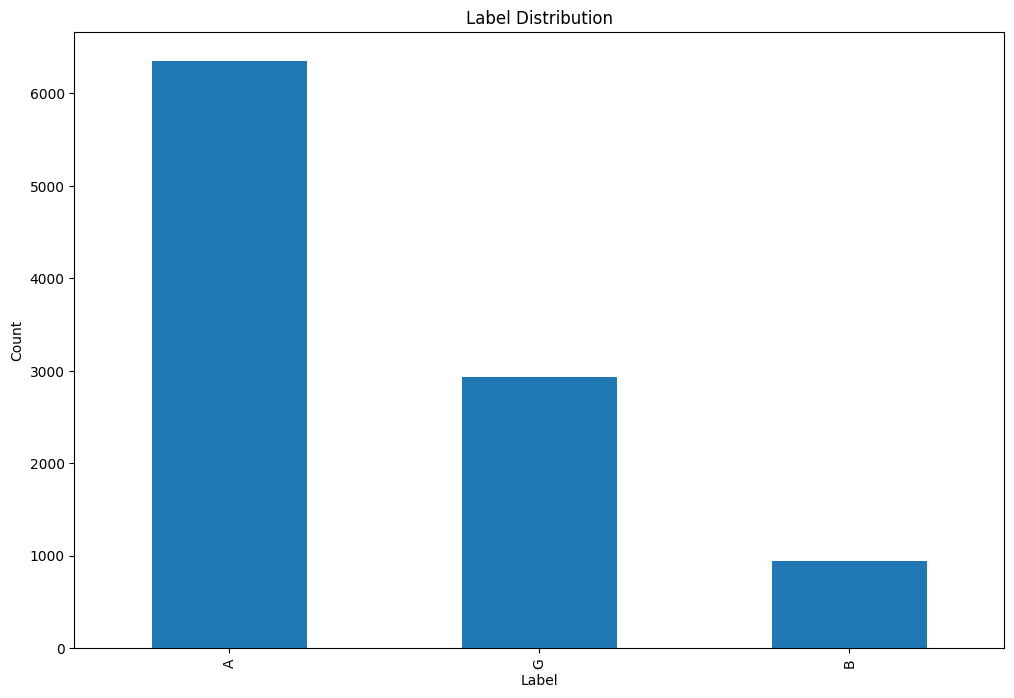

In [26]:
plt.figure(figsize=(12, 8))  
data["Label"].value_counts().plot(kind='bar')

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show() 

From the plot, it is evident that the dataset is imbalanced.

**Label A** has the highest number of images followed by **Label G** and then **label B**. This imbalance will impact the performance of the models as they might be biased towards **label A**. To solve this issue we may need to apply data augmentation for the underrepresented classes.


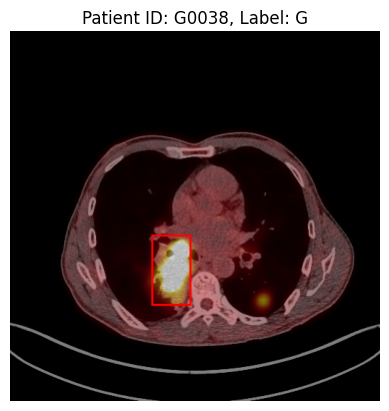

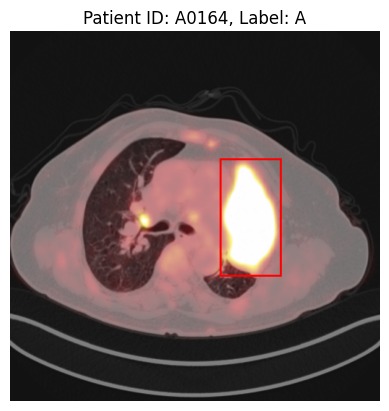

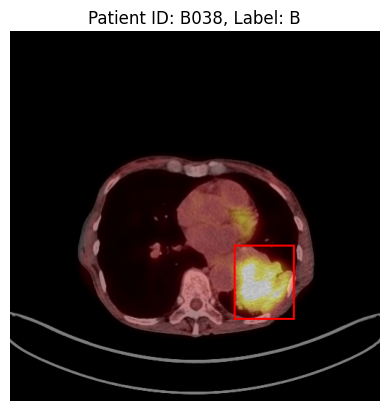

In [32]:
def Extract_annotation(annotation_path, img_width, img_height):
    """
    This Function is to extract the information from annotataion file 
    :param annotation_path: the annotation file path 
    :param img_width: image width
    :param img_height: image height
    :return: a list of box coordinates 
    """
    boxes = []
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                # Extract class and bounding box coordinates
                cls, x_center, y_center, width, height = map(float, parts)
                # Get the coordinates 
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height
                x_min = int(x_center - width / 2)
                x_max = int(x_center + width / 2)
                y_min = int(y_center - height / 2)
                y_max = int(y_center + height / 2)
                boxes.append((x_min, y_min, x_max, y_max))
    return boxes

# Function to visualize a sample
def visualization(row):
    image_path = row['Image Path']
    annotation_path = row['Annotation Path']
    patient_id = row['Patient ID']
    label = row['Label']
    
    # Open the image
    image = Image.open(image_path)
    img_width, img_height = image.size
    
    # Get the information of box coordinates
    boxes = []
    if os.path.exists(annotation_path):
        boxes = Extract_annotation(annotation_path, img_width, img_height)
    
    # Draw the bounding boxes on the image
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(box, outline='red', width=2)
    
    # Displaying the image
    plt.imshow(image)
    plt.title(f'Patient ID: {patient_id}, Label: {label}')
    plt.axis('off')
    plt.show()


unique_labels = data['Label'].unique()

# iterate through labels and Visualize a random sample from each label
for label in unique_labels:
    sample = data[data['Label'] == label].sample(1).iloc[0]
    visualization(sample)


During various iterations, it was very evident that some images do not have tumour in the images, which might causes confusion for the models later. In order to reduce this issue, it's important to deploy image quality metric. In this research we have choosen to use **BRISQUE** metric 
 

# BRISQUE Implementation and Deployment

## Cloning repository

In [34]:
!git clone --filter=blob:none --no-checkout https://github.com/spmallick/learnopencv.git

Cloning into 'learnopencv'...
remote: Enumerating objects: 7337, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 7337 (delta 53), reused 156 (delta 34), pack-reused 7129
Receiving objects: 100% (7337/7337), 1.83 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (2984/2984), done.


In [36]:
!cd "/home/ahmed/PycharmProjects/Lung_Cancer/learnopencv"

In [37]:
!git sparse-checkout set --cone 

In [38]:
!git checkout master

Already on 'master'
Your branch is up to date with 'origin/master'.


In [40]:
!git sparse-checkout set ImageMetrics

remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 156 (delta 1), reused 1 (delta 1), pack-reused 154
Receiving objects: 100% (156/156), 1.69 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (28/28), done.


The previous steps outline the process of cloning a file from a large repository.

In order to work on this steps follow these steps:

For Python 3.x :

cd Python/libsvm/

make

cd python

make

In [5]:
os.chdir("/home/ahmed/PycharmProjects/Lung_Cancer/learnopencv/ImageMetrics/Python/libsvm")

In [7]:
!make

make: Nothing to be done for 'all'.


In [8]:
os.chdir("/home/ahmed/PycharmProjects/Lung_Cancer/learnopencv/ImageMetrics/Python/libsvm/python")

In [9]:
!make

make -C .. lib
make[1]: Entering directory '/home/ahmed/PycharmProjects/Lung_Cancer/learnopencv/ImageMetrics/Python/libsvm'
if [ "Linux" = "Darwin" ]; then \
	SHARED_LIB_FLAG="-dynamiclib -Wl,-install_name,libsvm.so.2"; \
else \
	SHARED_LIB_FLAG="-shared -Wl,-soname,libsvm.so.2"; \
fi; \
g++ ${SHARED_LIB_FLAG} svm.o -o libsvm.so.2
make[1]: Leaving directory '/home/ahmed/PycharmProjects/Lung_Cancer/learnopencv/ImageMetrics/Python/libsvm'


In [4]:
os.chdir("/home/ahmed/PycharmProjects/Lung_Cancer")

## BRISQUE deployment

In [8]:
def remove_low_quality_images(root_folder):
    # Define the image extensions you want to include
    image_extensions = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif', '*.tiff')

    # Loop through each subfolder in the root folder
    for subdir, _, _ in os.walk(root_folder):
        for extension in image_extensions:
            # Use glob to find all images with the current extension in the current subdir
            for image_path in glob.glob(os.path.join(subdir, extension)):
                qs=test_measure_BRISQUE(image_path)
                if qs > 25:
                    #print(f'Removing image: {image_path} with quality score: {qs}')
                    os.remove(image_path)


                    # Find and remove the corresponding text file
                    txt_file_path = os.path.splitext(image_path)[0] + '.txt'
                    if os.path.exists(txt_file_path):
                        #print(f'Removing corresponding text file: {txt_file_path}')
                        os.remove(txt_file_path)


remove_low_quality_images("/home/ahmed/PycharmProjects/Lung_Cancer/dataset")  

This code iterates through each image and calculate the BRISQUE metric for assessing image quality. We have set a BRISQUE threshold value of 25. any image higher than 25 will be removed from the dataset

According to [1],the threshold set for CT images is **20**, whereas for PET/CT images, it is **28**., based on the histogram analysis of both modalities. However, in this research, we adjusted the threshold to **25** to enhance the overall quality of the images

In [10]:
Metadata_creator(root_dir="/home/ahmed/PycharmProjects/Lung_Cancer/dataset",csv_file="BRISQUE25_MetaData.csv")

new Metadata was created of the higher quality images

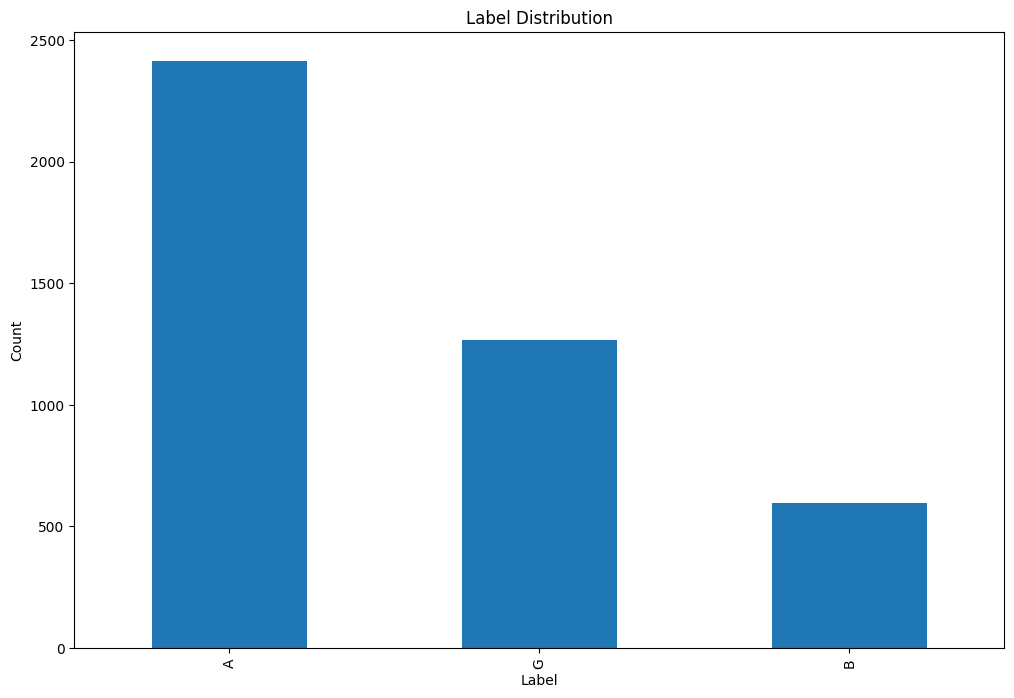

In [13]:
BRISQUE25_data = pd.read_csv("BRISQUE25_MetaData.csv")
plt.figure(figsize=(12, 8))  
BRISQUE25_data["Label"].value_counts().plot(kind='bar')

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show() 

The Data still have the same distribution with **Label A** containing the most images, followed by **Label G** and then **Label B**

The next step is to split the data to (train,valid and test), the apply data augmentation on the training set specially class B and G 


# Data Splitting

In [15]:
BRISQUE25_data.head() 

,Patient ID,Label,Image Path,Annotation Path
0,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
1,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
2,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
3,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
4,G0055,G,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Get unique patients and create a mapping from Patient_ID to Label
patient_labels = BRISQUE25_data.groupby('Patient ID')['Label'].apply(lambda x: x.mode()[0])

# First, split patients into training (50%) and test+validation (50%)
train_val_patients, test_patients = train_test_split(
    patient_labels.index, 
    test_size=0.50, 
    random_state=42,  # For reproducibility
    stratify=patient_labels
)

# Then, split test+validation patients into validation (25%) and testing (25%)
val_patients, test_patients = train_test_split(
    test_patients, 
    test_size=0.50,  # 50% of the remaining 50% -> 25% of original data
    random_state=42,  # For reproducibility
    stratify=patient_labels[test_patients]
)

# Create training, validation, and testing datasets based on patient splits
train_df = BRISQUE25_data[BRISQUE25_data['Patient ID'].isin(train_val_patients)]
valid_df = BRISQUE25_data[BRISQUE25_data['Patient ID'].isin(val_patients)]
test_df = BRISQUE25_data[BRISQUE25_data['Patient ID'].isin(test_patients)]

# Check the label distributions to verify stratification
print("Training set label distribution:")
print(train_df['Label'].value_counts(normalize=True))
print("\nValidation set label distribution:")
print(valid_df['Label'].value_counts(normalize=True))
print("\nTesting set label distribution:")
print(test_df['Label'].value_counts(normalize=True))

# Optionally save these datasets to CSV files
train_df.to_csv('train.csv', index=False)
valid_df.to_csv('valid.csv', index=False)
test_df.to_csv('test.csv', index=False)


Training set label distribution:
Label
A    0.565540
G    0.275900
B    0.158559
Name: proportion, dtype: float64

Validation set label distribution:
Label
A    0.508850
G    0.338496
B    0.152655
Name: proportion, dtype: float64

Testing set label distribution:
Label
A    0.631811
G    0.321060
B    0.047128
Name: proportion, dtype: float64


The data was partitioned by patient, which is an important step to ensure data integrity and to prevent **data leakage**. This method ensure that information from the same patient does not appear in both the training and validation sets, therefore maintaining the validity and reliability of the analysis.

We use stratification to ensure that the class distribution is preserved in each split. which is an important in medical data. Stratification helps to ensure that each split has a representative distribution of classes, leading to more reliable training and evaluation.


In [19]:
# Converts Patient ID to list 
A = train_df["Patient ID"].tolist()
B = valid_df["Patient ID"].tolist()
C = test_df["Patient ID"].tolist()

# Convert the list to set to remove duplicates 
A = set(A)
B = set(B)
C = set(C)

# Final the intersection between the sets 
Final = set.intersection(A,B)
print(Final)

Final = set.intersection(A,C)
print(Final)

Final = set.intersection(B,C)
print(Final)

Final = set.intersection(A,B,C)
print(Final)

set()
set()
set()
set()


This code ensures that there is no overlap of patient data between the training, validation, and testing sets.This approach is critical to make sure there is no data leakage and get result the represent the reality 


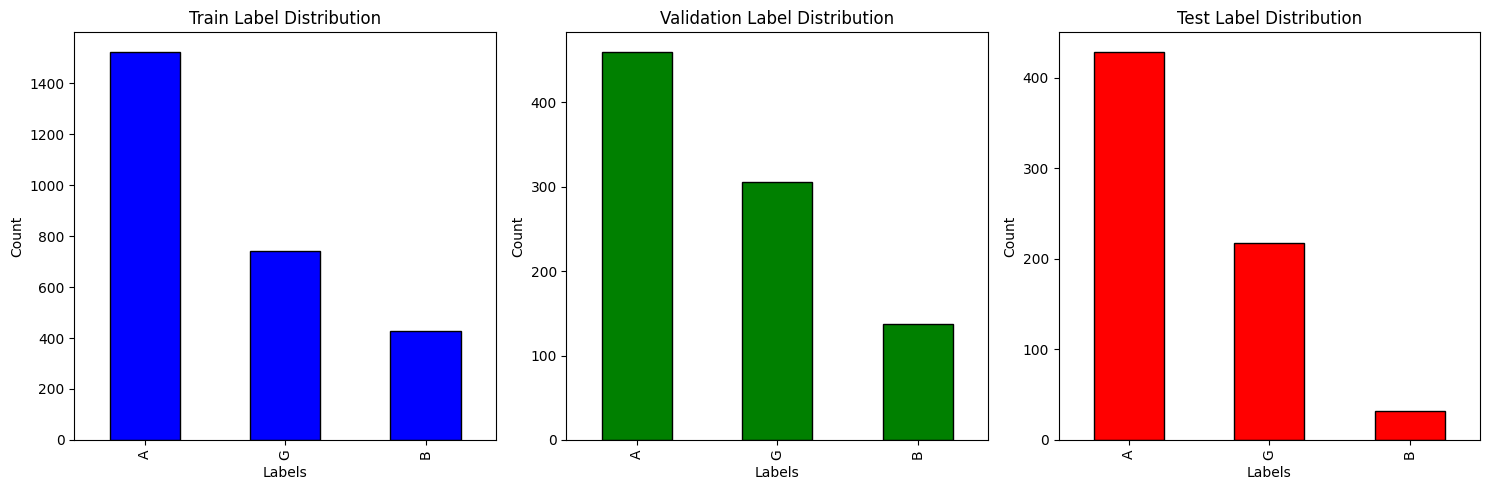

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))

# Training Data Distribution
plt.subplot(1, 3, 1)
train_df["Label"].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Train Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

# Validation Data Distribution
plt.subplot(1, 3, 2)
valid_df["Label"].value_counts().plot(kind='bar', color='green', edgecolor='black')
plt.title('Validation Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

# Testing Data Distribution
plt.subplot(1, 3, 3)
test_df["Label"].value_counts().plot(kind='bar', color='red', edgecolor='black')
plt.title('Test Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.tight_layout()

plt.show()


**The Three classes have the same distribution** 
1. All three sets show class imbalance where Class A being the majority and Class B the minority
2. The validation and test sets have been stratified to maintain the original data distribution
3. The training set will undergo augmentation to balance classes and prevent bias
4. Evaluation metrics should account for this class imbalance, especially in validation and testing


In [32]:
train_df.head(1)

,Patient ID,Label,Image Path,Annotation Path
79,A0242,A,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...


In [33]:
def process_csv(file_path, dataset_type):
    df = pd.read_csv(file_path)
    
    # Iterate over every row in the DataFrame
    for index, row in df.iterrows():
        patient_id = row['Patient ID']
        label = row['Label']
        image_path = row['Image Path']
        annotation_path = row['Annotation Path']
        

        label_dir = os.path.join(output_base_dir, dataset_type, label)
        os.makedirs(label_dir, exist_ok=True)
        
        # Copy the image and annotation files to the label directory
        image_dest = os.path.join(label_dir, os.path.basename(image_path))
        annotation_dest = os.path.join(label_dir, os.path.basename(annotation_path))
        
        shutil.copy(image_path, image_dest)
        shutil.copy(annotation_path, annotation_dest)
        
        print(f"Processed patient_id: {patient_id}, label: {label}, dataset: {dataset_type}")

# Define the paths to the CSV files
csv_files = {
    'train': 'train.csv',
    'test': 'test.csv',
    'valid': 'valid.csv'
}
# output_directory path
output_base_dir = '/home/ahmed/PycharmProjects/Lung_Cancer/Final_dataset'

for dataset_type, file_path in csv_files.items():
    process_csv(file_path, dataset_type)




Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242, label: A, dataset: train
Processed patient_id: A0242,

# Data Augmentation

The augmentation techniques, such as rotation, flipping, adding noise, blurring, and adjusting brightness and contrast, are defined using the Albumentations library. These transformations help to create a more robust training dataset by simulating different real-world variations and distortions that the model might encounter, ultimately improving its generalization capabilities.

**Note** : Data Augmentation is only done to the training data. Not Validation or Testing


In [23]:
train_df.head(2)

,Patient ID,Label,Image Path,Annotation Path
79,A0242,A,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...
80,A0242,A,/home/ahmed/PycharmProjects/Lung_Cancer/datase...,/home/ahmed/PycharmProjects/Lung_Cancer/datase...


In [35]:

def load_yolo_annotation(annotation_path):
    bboxes = []
    class_labels = []
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data = line.strip().split()
            class_labels.append(int(data[0]))
            bboxes.append([float(x) for x in data[1:]])
    return bboxes, class_labels

# Function to save YOLO annotation
def save_yolo_annotation(annotation_path, bboxes, class_labels):
    with open(annotation_path, 'w') as file:
        for bbox, label in zip(bboxes, class_labels):
            file.write(f"{label} {' '.join(map(str, bbox))}\n")
            
            
# Input & Out Dir
input_dir = '/home/ahmed/PycharmProjects/Lung_Cancer/Final_dataset/train'
output_dir = '/home/ahmed/PycharmProjects/Lung_Cancer/Final_dataset/Aug/'

os.makedirs(output_dir, exist_ok=True)

# Define augmentations per class "Since some class have high number of images "
class_augmentations = {
    'A': 0,
    'B': 3,
    'G': 1
}

# Define the augmentation pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.GaussNoise(p=0.2),
        A.MultiplicativeNoise(p=0.2),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.ElasticTransform(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))



for class_name in os.listdir(input_dir):
    class_dir = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Create output subdirectory for this class
    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    # Get number of augmentations for this class
    num_augmentations = class_augmentations.get(class_name, 1)  # Default to 1 if class not specified

    # Iterate through images in the class subdirectory
    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            # Load image
            image_path = os.path.join(class_dir, filename)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            # Load corresponding annotation
            annotation_path = os.path.splitext(image_path)[0] + '.txt'
            if not os.path.exists(annotation_path):
                continue
            bboxes, class_labels = load_yolo_annotation(annotation_path)

            # Save original image and annotation
            Image.fromarray(image).save(os.path.join(class_output_dir, filename))
            save_yolo_annotation(os.path.join(class_output_dir, os.path.splitext(filename)[0] + '.txt'), bboxes, class_labels)

            # Create augmented versions
            for i in range(num_augmentations):
                # Apply augmentation
                augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                augmented_image = augmented['image']
                augmented_bboxes = augmented['bboxes']
                augmented_class_labels = augmented['class_labels']

                # Save augmented image and annotation
                base_filename, ext = os.path.splitext(filename)
                augmented_image_path = os.path.join(class_output_dir, f'{base_filename}_aug_{i + 1}{ext}')
                augmented_annotation_path = os.path.join(class_output_dir, f'{base_filename}_aug_{i + 1}.txt')
                Image.fromarray(augmented_image).save(augmented_image_path)
                save_yolo_annotation(augmented_annotation_path, augmented_bboxes, augmented_class_labels)

print("Augmentation complete!")


Augmentation complete!


This code perform Data Augmentation on two classes which are underrepresented 

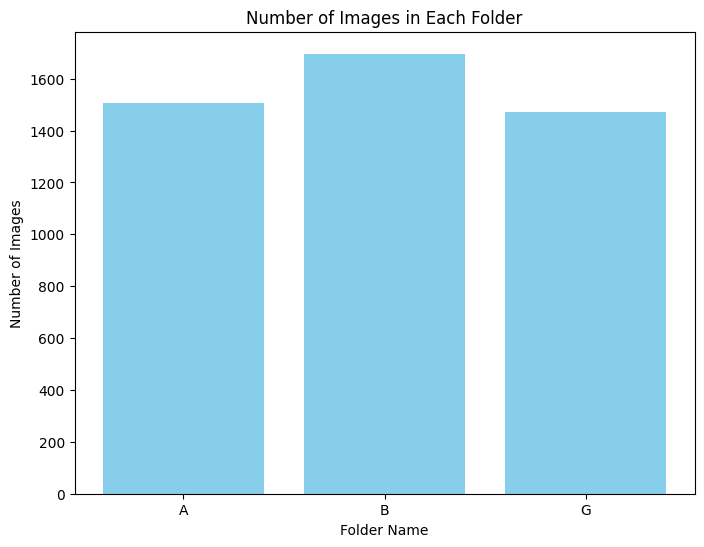

In [37]:
import os
import matplotlib.pyplot as plt

# Define the folder paths
folder_paths = ['/home/ahmed/PycharmProjects/Lung_Cancer/Final_dataset/Aug/A', '/home/ahmed/PycharmProjects/Lung_Cancer/Final_dataset/Aug/B',
                '/home/ahmed/PycharmProjects/Lung_Cancer/Final_dataset/Aug/G']

# Initialize lists for folder names and image counts
folders = []
image_counts = []

# Define a set of image extensions
image_extensions = {'.png', '.jpg'}

# Count the number of images in each folder
for folder in folder_paths:
    count = sum(1 for file in os.listdir(folder) if os.path.splitext(file)[1].lower() in image_extensions)
    folders.append(os.path.basename(folder))  
    image_counts.append(count)

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(folders, image_counts, color='skyblue')

# Add labels and title
plt.xlabel('Folder Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Folder')

# Show plot
plt.show()


In [38]:
Train_ratio = np.sum(image_counts)/(np.sum(image_counts)+valid_df.shape[0]+test_df.shape[0])
valid_ratio = valid_df.shape[0]/(np.sum(image_counts)+valid_df.shape[0]+test_df.shape[0])
test_ratio = test_df.shape[0]/(np.sum(image_counts)+valid_df.shape[0]+test_df.shape[0])

print("Train Ratio: ", Train_ratio, "Valid Ratio: ", valid_ratio, "Test Ratio: ", test_ratio)

Train Ratio:  0.7470033562410101 Valid Ratio:  0.14447818443343455 Test Ratio:  0.10851845932555537
